# 使用 TCN-AE（時間卷積神經網路 ＋ 自動編碼器）進行齒輪振動 - 時序資料 - 的缺陷診斷

<table class="colab-tcn-buttons" align="left">
  <td>
    <a href="https://colab.research.google.com/github/iinoshirozheng/gear-tcn-ae/blob/main/src/gear_tcn_ae.ipynb" target="_blank" ><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />在 Google Colab 上面執行</a>
  </td>
  <td>
    <a href="https://github.com/iinoshirozheng/gear-tcn-ae" target="_blank" ><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />在我的 GitHub 上查看源碼</a>
  </td>
</table>

請注意以下幾點：
- 使用 Google CoLab 時，因為訓練時間較長，請記得啟動 GPU 加速：
   - 到上方選單找到 編輯→筆記本設置
   - 從硬件加速器下拉列表中選擇 GPU

In [1]:
#
# 首先檢查是否在 Google CoLab 上執行
#
import numpy as np

IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
    print('Running on Google CoLab!')
else:
    print('Not running on Google CoLab!')

Not running on Google CoLab!


In [2]:
#
# 下載必須要用的 packages 以及 repository
#
import os
if IN_COLAB:
    !pip3 install keras-tcn
    if not os.path.exists('/content/gear-tcn-ae/'):
        print("Repo not cloned yet. Do it now!")
        !git clone https://github.com/iinoshirozheng/gear-tcn-ae /content/gear-tcn-ae/
    else:
        print("Repository already cloned!")

In [3]:
#
# In Google CoLab: 更變資料夾到 gear-tcn-ae/src
#
if IN_COLAB and os.getcwd() != "/content/gear-tcn-ae/src":
  # Print the current working directory
  print("Old working directory: {0}".format(os.getcwd()))

  # Change the current working directory
  os.chdir('/content/gear-tcn-ae/src')

  # Print the current working directory
  print("New working directory: {0}".format(os.getcwd()))

In [4]:
#
# 如果這邊錯誤 ，代表 GPU 沒有開啟 ，請確認有將 GPU 開啟
#
if IN_COLAB:
    %tensorflow_version 2.x
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found -- please open the GPU')
    print('Found GPU at: {}'.format(device_name))
    !nvidia-smi

In [5]:
# import packages
import os
import warnings
warnings.filterwarnings('ignore')
import time
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import AveragePooling1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import pandas
import numpy
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
#print(tensorflow.test.is_gpu_available())

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12820293392256620838
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2392123392
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11677201323791226983
 physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:c1:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [7]:

# Keras Implementation of Mish Activation Function.


# Import Necessary Modules.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Layer

class Mish(Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
    #    >>> X_input = Input(input_shape)
    #    >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        config = super(Mish, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        return input_shape

In [8]:
import tensorflow
from tensorflow.keras import backend as K, Model, optimizers
# pylint: disable=E0611
from tensorflow.keras.layers import Activation, SpatialDropout1D, Lambda
# pylint: disable=E0611
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, Dense, BatchNormalization, LayerNormalization, Minimum
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Concatenate
from keras.layers.convolutional import Conv1DTranspose

""" Making new Layers and Models via subclassing
    Ref: https://zhuanlan.zhihu.com/p/336511055
"""

# An adaptively parametric rectifier linear unit (APReLU)
def aprelu(inputs):
    # get the number of channels
    channels = inputs.get_shape().as_list()[-1]
    # get a zero feature map
    zeros_input = tensorflow.keras.layers.subtract([inputs, inputs])
    # get a feature map with only positive features
    pos_input = Activation('relu')(inputs)
    # get a feature map with only negative features
    neg_input = Minimum()([inputs,zeros_input])
    # define a network to obtain the scaling coefficients
    scales_p = Lambda(lambda x: K.mean(x, axis=1, keepdims=True))(GlobalAveragePooling1D()(pos_input))
    scales_n = Lambda(lambda x: K.mean(x, axis=1, keepdims=True))(GlobalAveragePooling1D()(neg_input))
    scales = Concatenate()([scales_n, scales_p])
    scales = Dense(channels, activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(scales)
    scales = BatchNormalization(momentum=0.9, gamma_regularizer=l2(1e-4))(scales)
    scales = Activation('relu')(scales)
    scales = Dense(channels, activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(scales)
    scales = BatchNormalization(momentum=0.9, gamma_regularizer=l2(1e-4))(scales)
    scales = Activation('sigmoid')(scales)

    # apply a paramtetric relu
    neg_part = tensorflow.keras.layers.multiply([tensorflow.expand_dims(scales,axis=1), neg_input])
    return tensorflow.keras.layers.add([pos_input, neg_part])


In [9]:
def length_network(kernel, dilate):
    return (kernel + 2**(dilate-1))*(kernel-1) +1

length_network(24, 7)

2025

In [10]:
import inspect
from typing import List

from tensorflow.keras import backend as K, Model, Input, optimizers
# pylint: disable=E0611
from tensorflow.keras import layers
# pylint: disable=E0611
from tensorflow.keras.layers import Activation, SpatialDropout1D, Lambda
# pylint: disable=E0611
from tensorflow.keras.layers import Layer, Conv1D, Dense, BatchNormalization, LayerNormalization
import tensorflow

class SE_Block(Layer):
    def __init__(self,reduction = 16,**kwargs):
        super(SE_Block,self).__init__(**kwargs)
        tensorflow.config.run_functions_eagerly(True)
        self.reduction = reduction
    def build(self, input_shape):
        pass
    @tensorflow.function
    def call(self, inputs):
        num_filters = inputs.shape[-1]
        squeeze = tensorflow.keras.layers.GlobalAveragePooling1D()(inputs)

        excitation = tensorflow.keras.layers.Dense(units=num_filters/self.reduction)(squeeze)
        excitation = tensorflow.keras.layers.Activation('relu')(excitation)
        excitation = tensorflow.keras.layers.Dense(units=num_filters)(excitation)
        excitation = tensorflow.keras.layers.Activation('sigmoid')(excitation)
        excitation = tensorflow.keras.layers.Reshape([1, num_filters])(excitation)

        scale = inputs * excitation

        return scale


def is_power_of_two(num: int):
    return num != 0 and ((num & (num - 1)) == 0)


def adjust_dilations(dilations: list):
    if all([is_power_of_two(i) for i in dilations]):
        return dilations
    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations


class ResidualBlock(Layer):

    def __init__(self,
                 dilation_rate: int,
                 nb_filters: int,
                 kernel_size: int,
                 padding: str,
                 activation: str = 'relu',
                 dropout_rate: float = 0,
                 kernel_initializer: str = 'he_normal',
                 use_batch_norm: bool = False,
                 use_layer_norm: bool = False,
                 use_weight_norm: bool = False,
                 **kwargs):
        """Defines the residual block for the WaveNet TCN
        Args:
            x: The previous layer in the model
            training: boolean indicating whether the layer should behave in training mode or in inference mode
            dilation_rate: The dilation power of 2 we are using for this residual block
            nb_filters: The number of convolutional filters to use in this block
            kernel_size: The size of the convolutional kernel
            padding: The padding used in the convolutional layers, 'same' or 'causal'.
            activation: The final activation used in o = Activation(x + F(x))
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any initializers for Layer class.
        """

        self.dilation_rate = dilation_rate
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.kernel_initializer = kernel_initializer
        self.layers = []
        self.shape_match_conv = None
        self.res_output_shape = None
        self.final_activation = None

        super(ResidualBlock, self).__init__(**kwargs)

    def _build_layer(self, layer):
        """Helper function for building layer
        Args:
            layer: Appends layer to internal layer list and builds it based on the current output
                   shape of ResidualBlocK. Updates current output shape.
        """
        self.layers.append(layer)
        self.layers[-1].build(self.res_output_shape)
        self.res_output_shape = self.layers[-1].compute_output_shape(self.res_output_shape)

    def build(self, input_shape):

        with K.name_scope(self.name):  # name scope used to make sure weights get unique names
            self.layers = []
            self.res_output_shape = input_shape

            for k in range(2):  # dilated conv block.
                name = 'conv1D_{}'.format(k)
                with K.name_scope(name):  # name scope used to make sure weights get unique names
                    conv = Conv1D(
                        filters=self.nb_filters,
                        kernel_size=self.kernel_size,
                        dilation_rate=self.dilation_rate,
                        padding=self.padding,
                        name=name,
                        kernel_initializer=self.kernel_initializer
                    )
                    if self.use_weight_norm:
                        from tensorflow_addons.layers import WeightNormalization
                        # wrap it. WeightNormalization API is different than BatchNormalization or LayerNormalization.
                        with K.name_scope('norm_{}'.format(k)):
                            conv = WeightNormalization(conv)
                    self._build_layer(conv)

                with K.name_scope('norm_{}'.format(k)):
                    if self.use_batch_norm:
                        self._build_layer(BatchNormalization())
                    elif self.use_layer_norm:
                        self._build_layer(LayerNormalization())
                    elif self.use_weight_norm:
                        pass  # done above.

                with K.name_scope('act_and_dropout_{}'.format(k)):
                    self._build_layer(Activation(self.activation, name='Act_Conv1D_{}'.format(k)))
                    self._build_layer(SpatialDropout1D(rate=self.dropout_rate, name='SDropout_{}'.format(k)))

            if self.nb_filters != input_shape[-1]:
                # 1x1 conv to match the shapes (channel dimension).
                name = 'matching_conv1D'
                with K.name_scope(name):
                    # make and build this layer separately because it directly uses input_shape.
                    # 1x1 conv.
                    self.shape_match_conv = Conv1D(
                        filters=self.nb_filters,
                        kernel_size=1,
                        padding='same',
                        name=name,
                        kernel_initializer=self.kernel_initializer
                    )
            else:
                name = 'matching_identity'
                self.shape_match_conv = Lambda(lambda x: x, name=name)

            with K.name_scope(name):
                self.shape_match_conv.build(input_shape)
                self.res_output_shape = self.shape_match_conv.compute_output_shape(input_shape)

            self._build_layer(Activation(self.activation, name='Act_Conv_Blocks'))
            self.final_activation = Activation(self.activation, name='Act_Res_Block')
            self.final_activation.build(self.res_output_shape)  # probably isn't necessary

            # this is done to force Keras to add the layers in the list to self._layers
            for layer in self.layers:
                self.__setattr__(layer.name, layer)
            self.__setattr__(self.shape_match_conv.name, self.shape_match_conv)
            self.__setattr__(self.final_activation.name, self.final_activation)

            super(ResidualBlock, self).build(input_shape)  # done to make sure self.built is set True

    def call(self, inputs, training=None, **kwargs):
        """
        Returns: A tuple where the first element is the residual model tensor, and the second
                 is the skip connection tensor.
        """
        # https://arxiv.org/pdf/1803.01271.pdf  page 4, Figure 1 (b).
        # x1: Dilated Conv -> Norm -> Dropout (x2).
        # x2: Residual (1x1 matching conv - optional).
        # Output: x1 + x2.
        # x1 -> connected to skip connections.
        # x1 + x2 -> connected to the next block.
        #       input
        #     x1      x2
        #   conv1D    1x1 Conv1D (optional)
        #    ...
        #   conv1D
        #    ...
        #       x1 + x2
        x1 = inputs
        for layer in self.layers:
            training_flag = 'training' in dict(inspect.signature(layer.call).parameters)
            x1 = layer(x1, training=training) if training_flag else layer(x1)
        # x1 = SE_Block(reduction=16)(x1)

        # print('x1.shape = ',x1.shape)
        x2 = self.shape_match_conv(inputs)
        x1_x2 = self.final_activation(layers.add([x2, x1], name='Add_Res'))
        return [x1_x2, x1]

    def compute_output_shape(self, input_shape):
        return [self.res_output_shape, self.res_output_shape]


class TCN(Layer):
    """Creates a TCN layer.
        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).
        Args:
            nb_filters: The number of filters to use in the convolutional layers. Can be a list.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            activation: The activation used in the residual blocks o = Activation(x + F(x)).
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any other arguments for configuring parent class Layer. For example "name=str", Name of the model.
                    Use unique names when using multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=3,
                 nb_stacks=1,
                 dilations=(1, 2, 4, 8, 16, 32),
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=False,
                 activation='relu',
                 kernel_initializer='he_normal',
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False,
                 **kwargs):

        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.activation = activation
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.skip_connections = []
        self.residual_blocks = []
        self.layers_outputs = []
        self.build_output_shape = None
        self.slicer_layer = None  # in case return_sequence=False
        self.output_slice_index = None  # in case return_sequence=False
        self.padding_same_and_time_dim_unknown = False  # edge case if padding='same' and time_dim = None

        if self.use_batch_norm + self.use_layer_norm + self.use_weight_norm > 1:
            raise ValueError('Only one normalization can be specified at once.')

        if isinstance(self.nb_filters, list):
            assert len(self.nb_filters) == len(self.dilations)
            if len(set(self.nb_filters)) > 1 and self.use_skip_connections:
                raise ValueError('Skip connections are not compatible '
                                 'with a list of filters, unless they are all equal.')

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        # initialize parent class
        super(TCN, self).__init__(**kwargs)

    @property
    def receptive_field(self):
        return 1 + 2 * (self.kernel_size - 1) * self.nb_stacks * sum(self.dilations)

    def build(self, input_shape):

        # member to hold current output shape of the layer for building purposes
        self.build_output_shape = input_shape

        # list to hold all the member ResidualBlocks
        self.residual_blocks = []
        total_num_blocks = self.nb_stacks * len(self.dilations)
        if not self.use_skip_connections:
            total_num_blocks += 1  # cheap way to do a false case for below

        for s in range(self.nb_stacks):
            for i, d in enumerate(self.dilations):
                res_block_filters = self.nb_filters[i] if isinstance(self.nb_filters, list) else self.nb_filters
                self.residual_blocks.append(ResidualBlock(dilation_rate=d,
                                                          nb_filters=res_block_filters,
                                                          kernel_size=self.kernel_size,
                                                          padding=self.padding,
                                                          activation=self.activation,
                                                          dropout_rate=self.dropout_rate,
                                                          use_batch_norm=self.use_batch_norm,
                                                          use_layer_norm=self.use_layer_norm,
                                                          use_weight_norm=self.use_weight_norm,
                                                          kernel_initializer=self.kernel_initializer,
                                                          name='residual_block_{}'.format(len(self.residual_blocks))))
                # build newest residual block
                self.residual_blocks[-1].build(self.build_output_shape)
                self.build_output_shape = self.residual_blocks[-1].res_output_shape

        # this is done to force keras to add the layers in the list to self._layers
        for layer in self.residual_blocks:
            self.__setattr__(layer.name, layer)

        self.output_slice_index = None
        if self.padding == 'same':
            time = self.build_output_shape.as_list()[1]
            if time is not None:  # if time dimension is defined. e.g. shape = (bs, 500, input_dim).
                self.output_slice_index = int(self.build_output_shape.as_list()[1] / 2)
            else:
                # It will known at call time. c.f. self.call.
                self.padding_same_and_time_dim_unknown = True

        else:
            self.output_slice_index = -1  # causal case.
        self.slicer_layer = Lambda(lambda tt: tt[:, self.output_slice_index, :], name='Slice_Output')
        self.slicer_layer.build(self.build_output_shape.as_list())

    def compute_output_shape(self, input_shape):
        """
        Overridden in case keras uses it somewhere... no idea. Just trying to avoid future errors.
        """
        if not self.built:
            self.build(input_shape)
        if not self.return_sequences:
            batch_size = self.build_output_shape[0]
            batch_size = batch_size.value if hasattr(batch_size, 'value') else batch_size
            nb_filters = self.build_output_shape[-1]
            return [batch_size, nb_filters]
        else:
            # Compatibility tensorflow 1.x
            return [v.value if hasattr(v, 'value') else v for v in self.build_output_shape]

    def call(self, inputs, training=None, **kwargs):
        x = inputs
        self.layers_outputs = [x]
        self.skip_connections = []
        for res_block in self.residual_blocks:
            try:
                x, skip_out = res_block(x, training=training)
            except TypeError:  # compatibility with tensorflow 1.x
                x, skip_out = res_block(K.cast(x, 'float32'), training=training)
            self.skip_connections.append(skip_out)
            self.layers_outputs.append(x)

        if self.use_skip_connections:
            x = layers.add(self.skip_connections, name='Add_Skip_Connections')
            self.layers_outputs.append(x)

        if not self.return_sequences:
            # case: time dimension is unknown. e.g. (bs, None, input_dim).
            if self.padding_same_and_time_dim_unknown:
                self.output_slice_index = K.shape(self.layers_outputs[-1])[1] // 2
            x = self.slicer_layer(x)
            self.layers_outputs.append(x)
        return x

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(TCN, self).get_config()
        config['nb_filters'] = self.nb_filters
        config['kernel_size'] = self.kernel_size
        config['nb_stacks'] = self.nb_stacks
        config['dilations'] = self.dilations
        config['padding'] = self.padding
        config['use_skip_connections'] = self.use_skip_connections
        config['dropout_rate'] = self.dropout_rate
        config['return_sequences'] = self.return_sequences
        config['activation'] = self.activation
        config['use_batch_norm'] = self.use_batch_norm
        config['use_layer_norm'] = self.use_layer_norm
        config['use_weight_norm'] = self.use_weight_norm
        config['kernel_initializer'] = self.kernel_initializer
        return config

In [11]:

class TCNAE:
    """
    A class used to represent the Temporal Convolutional Autoencoder (TCN-AE).
    ...
    Attributes
    ----------
    model : xxtypexx
        The TCN-AE model.
    Methods
    -------
    build_model(verbose = 1)
        Builds the model
    """

    model = None

    def __init__(self,
                 ts_dimension = 3,
                 dilations = [],
                 nb_filters = [],
                 kernel_size = 20,
                 nb_stacks = 1,
                 padding = 'same',
                 activation = 'relu',
                 dropout_rate = 0.00,
                 filters_conv1d = 1,
                 activation_conv1d = 'linear',
                 latent_sample_rate = 32,
                 pooler = AveragePooling1D,
                 lr = 1e-5,
                 conv_kernel_init = 'glorot_normal',
                 loss = 'mean_squared_error',
                 use_early_stopping = False,
                 error_window_length = 128,
                 verbose = 1
                 ):
        """
        Parameters
        ----------
        ts_dimension : int
            The dimension of the time series (default is 1)
        dilations : tuple
            The dilation rates used in the TCN-AE model (default is (1, 2, 4, 8, 16))
        nb_filters : int
            The number of filters used in the dilated convolutional layers. All dilated conv. layers use the same number of filters (default is 20)
        """

        self.ts_dimension = ts_dimension
        self.dilations = dilations
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.nb_stacks = nb_stacks
        self.padding = padding
        self.dropout_rate = dropout_rate
        self.filters_conv1d = filters_conv1d
        self.activation = activation
        self.activation_conv1d = activation_conv1d
        self.latent_sample_rate = latent_sample_rate
        self.pooler = pooler
        self.lr = lr
        self.conv_kernel_init = conv_kernel_init
        self.loss = loss
        self.use_early_stopping = use_early_stopping
        self.error_window_length = error_window_length

        # build the model
        self.build_model(verbose = verbose)


    def build_model(self, verbose = 1):
        """Builds the TCN-AE model.
        If the argument `verbose` isn't passed in, the default verbosity level is used.
        Parameters
        ----------
        verbose : str, optional
            The verbosity level (default is 1)

        Returns
        -------
        KerasXYZType
        Todo
        Raises
        ------
        NotImplementedError
            If ...
        """

        tensorflow.keras.backend.clear_session()
        # sampling_factor = self.latent_sample_rate
        i = Input(batch_shape=(None, None, self.ts_dimension))

        # Put signal through TCN. Output-shape: (batch,sequence length, nb_filters)
        enc_in = TCN(nb_filters=20, kernel_size=self.kernel_size, nb_stacks=self.nb_stacks, dilations=[1,2,4,8,16],
                      padding=self.padding, use_skip_connections=False, dropout_rate=self.dropout_rate, return_sequences=True,use_weight_norm=False,
                      activation=self.activation, kernel_initializer=self.conv_kernel_init, name='tcn-enc')(i)

        # Now, adjust the number of channels...
        enc_flat = Conv1D(filters=8, kernel_size=1, activation=self.activation_conv1d, padding='valid')(enc_in)

        ## Do some average (max) pooling to get a compressed representation of the time series (e.g. a sequence of length 8)
        enc_pooled = self.pooler(pool_size=32, strides=None, padding='valid', data_format='channels_last')(enc_flat)

        # If you want, maybe put the pooled values through a non-linear Activation
        enc_out = Activation("linear")(enc_pooled)
        # enc_out = Conv1D(filters=1, kernel_size=1, activation='linear', padding='valid')(enc_pooled)

        # Now we should have a short sequence, which we will upsample again and then try to reconstruct the original series
        dec_upsample = UpSampling1D(size=32)(enc_out)

        dec_flat = Conv1D(filters=8, kernel_size=1, activation=self.activation_conv1d, padding='valid')(dec_upsample)

        dec_reconstructed = TCN(nb_filters=20, kernel_size=self.kernel_size, nb_stacks=self.nb_stacks, dilations=[1,2,4,8,16],
                                padding=self.padding, use_skip_connections=False, dropout_rate=self.dropout_rate, return_sequences=True,use_weight_norm=False,
                                activation=self.activation,kernel_initializer=self.conv_kernel_init, name='tcn-dec')(dec_flat)

        # Put the filter-outputs through a dense layer finally, to get the reconstructed signal
        o = Dense(self.ts_dimension, activation='linear')(dec_reconstructed)

        model = Model(inputs=[i], outputs=[o])

        adam = optimizers.Adam(lr=self.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=1e-4, amsgrad=True, clipnorm=1.)
        model.compile(loss=self.loss, optimizer=adam, metrics=[self.loss, 'acc'])
        if verbose > 1:
            model.summary()
        self.model = model

    def fit(self, train_X, train_Y, batch_size=32, epochs=40):
        my_callbacks = None
        if self.use_early_stopping:
            my_callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=1e-4, restore_best_weights=True)]

        print("> Starting the Training...")

        start = time.time()
        history = self.model.fit(train_X, train_Y,
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 validation_split=0.001,
                                 shuffle=True,
                                 callbacks=my_callbacks)
        print("> Training Time :", round(time.time() - start), "seconds.")
        return history

    def find_lr(self, x_train, y_train, batch_size = 64, epochs=10):
        import keras_lr_finder
        lr_finder = keras_lr_finder.LRFinder(self.model)
        lr_finder.find(x_train, y_train, 1e-7, 1, batch_size=batch_size, epochs=epochs)
        # Plot the loss, ignore 20 batches in the beginning and 5 in the end
        lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
        # Plot rate of change of the loss
        # Ignore 20 batches in the beginning and 5 in the end
        # Smooth the curve using simple moving average of 20 batches
        # Limit the range for y axis to (-0.02, 0.01)
        # lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.01, 0.01))

In [12]:
import numpy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def scale_data( data, scale_method = MinMaxScaler(feature_range=(-1, 1)), verbose = True):
    scaler = scale_method
    series = scaler.fit_transform(data)
    if verbose :
        import plotly.graph_objects as go

        line = go.Scatter(y = data[:, 0][:10240], name = "原始齒輪振動資料")
        init_data = go.Scatter(y = series[:, 0][:10240], name = "特徵處理後的資料")
        fig = go.Figure([line, init_data])
        fig.show()
    return scaler, series

filepath = 'C:/Users/user/Desktop/TCN/資料擷取/資料擷取_npy/filter_good.npy'
good = numpy.load(f'{filepath}')



scaler, GOOD = scale_data(good, verbose=True) # MinMaxScaler StandardScaler
GOOD = GOOD.reshape(-1, 2048, 3)
# GOOD_1 = GOOD.reshape(-1, 10240, 3)
# GOOD_2 = GOOD.reshape(-1, 2048, 3)
# print(GOOD_1.shape)
# print(GOOD_2.shape)
GOOD = GOOD[:1000].reshape(-1,2048,3)

In [13]:
##========================================
##Step1、build model
##Step2、訓練模型
tcn_ae = TCNAE(ts_dimension=3,lr = 1e-3, loss='logcosh', activation='tanh' ,padding='causal', conv_kernel_init = 'glorot_normal')

In [14]:
# find the fit learning_rate
# tcn_ae.find_lr(GOOD, GOOD,epochs=5)
tcn_ae.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 3)]         0         
                                                                 
 tcn-enc (TCN)               (None, None, 20)          73480     
                                                                 
 conv1d (Conv1D)             (None, None, 8)           168       
                                                                 
 average_pooling1d (AverageP  (None, None, 8)          0         
 ooling1D)                                                       
                                                                 
 activation (Activation)     (None, None, 8)           0         
                                                                 
 up_sampling1d (UpSampling1D  (None, None, 8)          0         
 )                                                           

In [15]:
history = tcn_ae.fit(GOOD,GOOD, batch_size=64, epochs=50)

> Starting the Training...
Epoch 1/50
16/16 [==============================] - 16s 251ms/step - loss: 0.0715 - logcosh: 0.0715 - acc: 0.4083 - val_loss: 0.0146 - val_logcosh: 0.0146 - val_acc: 0.6187
Epoch 2/50
16/16 [==============================] - 3s 191ms/step - loss: 0.0085 - logcosh: 0.0085 - acc: 0.5590 - val_loss: 0.0059 - val_logcosh: 0.0059 - val_acc: 0.6982
Epoch 3/50
16/16 [==============================] - 3s 195ms/step - loss: 0.0055 - logcosh: 0.0055 - acc: 0.6630 - val_loss: 0.0046 - val_logcosh: 0.0046 - val_acc: 0.6904
Epoch 4/50
16/16 [==============================] - 3s 188ms/step - loss: 0.0050 - logcosh: 0.0050 - acc: 0.6901 - val_loss: 0.0045 - val_logcosh: 0.0045 - val_acc: 0.7065
Epoch 5/50
16/16 [==============================] - 3s 191ms/step - loss: 0.0049 - logcosh: 0.0049 - acc: 0.6974 - val_loss: 0.0044 - val_logcosh: 0.0044 - val_acc: 0.7095
Epoch 6/50
16/16 [==============================] - 3s 187ms/step - loss: 0.0049 - logcosh: 0.0049 - acc: 0.6987

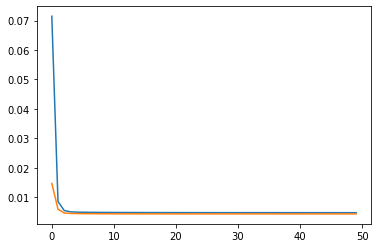

{'loss': [0.07145112752914429,
  0.008518648333847523,
  0.0054647005163133144,
  0.005019164644181728,
  0.004904512315988541,
  0.004865667317062616,
  0.004843845032155514,
  0.004828327335417271,
  0.004815864376723766,
  0.004805335309356451,
  0.0047964053228497505,
  0.004788700956851244,
  0.00478206155821681,
  0.004776304122060537,
  0.004771304316818714,
  0.004767008125782013,
  0.0047632004134356976,
  0.004759942647069693,
  0.004756999667733908,
  0.004754382651299238,
  0.004752056673169136,
  0.004749965388327837,
  0.004748097155243158,
  0.004746399354189634,
  0.004744855687022209,
  0.004743367433547974,
  0.004742026329040527,
  0.004740786738693714,
  0.00473953690379858,
  0.004738330841064453,
  0.004737173672765493,
  0.004736054223030806,
  0.0047349524684250355,
  0.00473383255302906,
  0.004732727073132992,
  0.004731643944978714,
  0.004730569198727608,
  0.0047295414842665195,
  0.004728567786514759,
  0.004727645311504602,
  0.004726758226752281,
  0.004

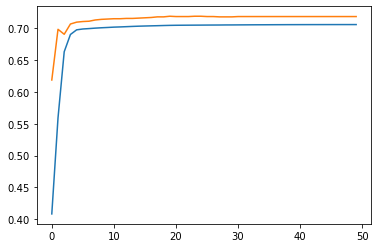

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
# plt.plot(history.history['acc'])
history.history

In [17]:


# print(tcn_ae.model.evaluate(scale_good, scale_good,batch_size=64))
# tcn_ae.model.save('C:/Users/user/Desktop/TCN/models/ehochs_10000.h5')

from sklearn.metrics import mean_absolute_error
test = tcn_ae.model.predict(GOOD)
mean_absolute_error(GOOD[0], test[0], sample_weight=None, multioutput='uniform_average')

0.07429552434661608

In [18]:
# utilities
def roll_fast(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return numpy.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def slide_window(df, window_length, verbose = 1):
    # orig_TS_list = []
    X_list = []
    series = df.copy()
    for i in series.columns.values: # loop through all input dimensions
        s = series[i]
        s2 = roll_fast(s.values, window_length)
        X_list.append(s2)
    X = numpy.dstack((X_list))
    if verbose > 2:
        print("X.shape:", X.shape)
    return X

# Computes the squared Mahalanobis distance of each data point (row)
# to the center of the distribution, described by cov and mu.
# (or any other point mu).
# If the parameters cov and mu are left empty, then this function
# will compute them based on the data X.
def mahalanobis_distance(X, cov=None, mu=None):
    if mu is None:
        mu = numpy.mean(X, axis=0)
    if cov is None:
        cov = numpy.cov(X, rowvar = False)
    try:
        inv_cov = numpy.linalg.inv(cov)
    except numpy.linalg.LinAlgError as err:
        print("Error, probably singular matrix!")
        inv_cov = numpy.eye(cov.shape[0])

    X_diff_mu = X - mu
    M = numpy.apply_along_axis(lambda x:
                               numpy.matmul(numpy.matmul(x, inv_cov), x.T) ,1 , X_diff_mu)
    return M

def get_anomaly_windows(is_anomaly):
    # add a zero at the beginning and end of the sequence and look for the edges of the anomaly windows
    edges = numpy.diff(numpy.concatenate([[0],is_anomaly,[0]])).nonzero()[0]
    return edges.reshape((-1,2)) + numpy.array([0,-1])

def predict(original, output, error_window_length = 128):

    # do some padding in the end, since not necessarily the whole time series is reconstructed
    X_rec = numpy.pad(output, ((0,0),(0, original.shape[0] - output.shape[0] ), (0,0)), 'constant')
    E_rec = (X_rec - original).squeeze()
    Err = slide_window(pandas.DataFrame(E_rec), error_window_length, verbose = 3)
    Err = Err.reshape(-1, Err.shape[-1]*Err.shape[-2])
    sel = numpy.random.choice(range(Err.shape[0]),int(Err.shape[0]*0.98))
    mu = numpy.mean(Err[sel], axis=0)
    cov = numpy.cov(Err[sel], rowvar = False)
    sq_mahalanobis = mahalanobis_distance(X=Err[:], cov=cov, mu=mu)
    print(len(sq_mahalanobis))
    # moving average over mahalanobis distance. Only slightly smooths the signal
    anomaly_score = numpy.convolve(sq_mahalanobis, numpy.ones((50,))/50, mode='same')
    anomaly_score = numpy.sqrt(anomaly_score)
    return anomaly_score

def plot_results( anomaly_score, threshold = 20, plot_anomaly_score = True):

    plot_range = (0,anomaly_score.size)
    extend_window = 0 # extend anomaly window, just to see something in the plot
    my_alpha = 0.4
    plt.figure(figsize=(25,8))

    if plot_anomaly_score:
        plt.plot(anomaly_score, 'b-', zorder=2)

    real_anoms = get_anomaly_windows(anomaly_score>threshold)

    for i in real_anoms:
        plt.axvspan(i[0]-extend_window,i[1]+extend_window, ymin=0.0, ymax=50, alpha=my_alpha, color='red')

    # ignorable_win = get_anomaly_windows(anomaly_score<1)
    # for i in ignorable_win:
    #     plt.axvspan(i[0],i[1], ymin=0.0, ymax=50, alpha=my_alpha)

    if plot_anomaly_score:
        plt.axhline(y=threshold, xmin=0.0, xmax=10240, color='red')

    plt.xlim(plot_range)
    plt.show()

In [19]:

def load_data(filepath):
    GOOD = numpy.load(f'{filepath}/Good.npy')
    BC = numpy.load(f'{filepath}/BC.npy')
    LOOSE = numpy.load(f'{filepath}/Loose.npy')
    SHAFT = numpy.load(f'{filepath}/Shaft.npy')
    TOOTH_BREAK = numpy.load(f'{filepath}/Tooth Break.npy')
    WEAR = numpy.load(f'{filepath}/Wear.npy')
    return [ GOOD, BC, LOOSE, SHAFT, TOOTH_BREAK, WEAR]

filepath = 'C:/Users/user/Desktop/TCN/資料擷取/資料擷取_npy/top'
all_data_top = load_data(filepath)
filepath = 'C:/Users/user/Desktop/TCN/資料擷取/資料擷取_npy/mid'
all_data_mid = load_data(filepath)
filepath = 'C:/Users/user/Desktop/TCN/資料擷取/資料擷取_npy/bot'
all_data_bot = load_data(filepath)


In [20]:
import plotly.graph_objects as go
from scipy import signal
import numpy

def lowpass_filter(data, step=2, pass_hz=250):
    wn=2* pass_hz/1000
    b,a = signal.butter(step,wn,btype='low',analog=False,output='ba')
    return signal.filtfilt(b,a,data)

future :  0
(10240, 3)
out.shape= (1, 10240, 3)
X.shape: (10113, 128, 1)
10113


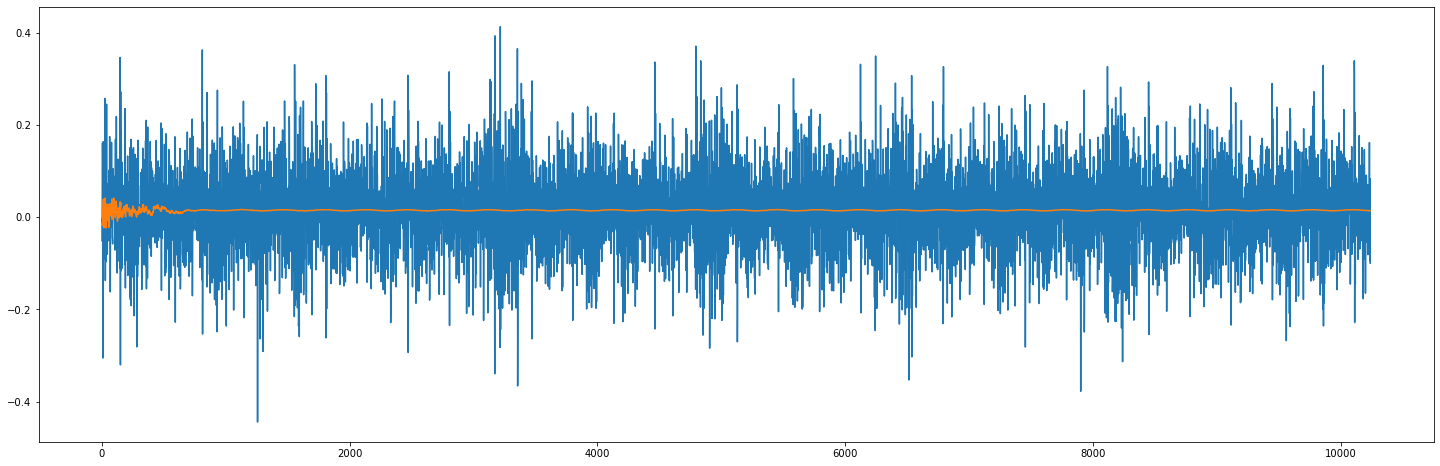

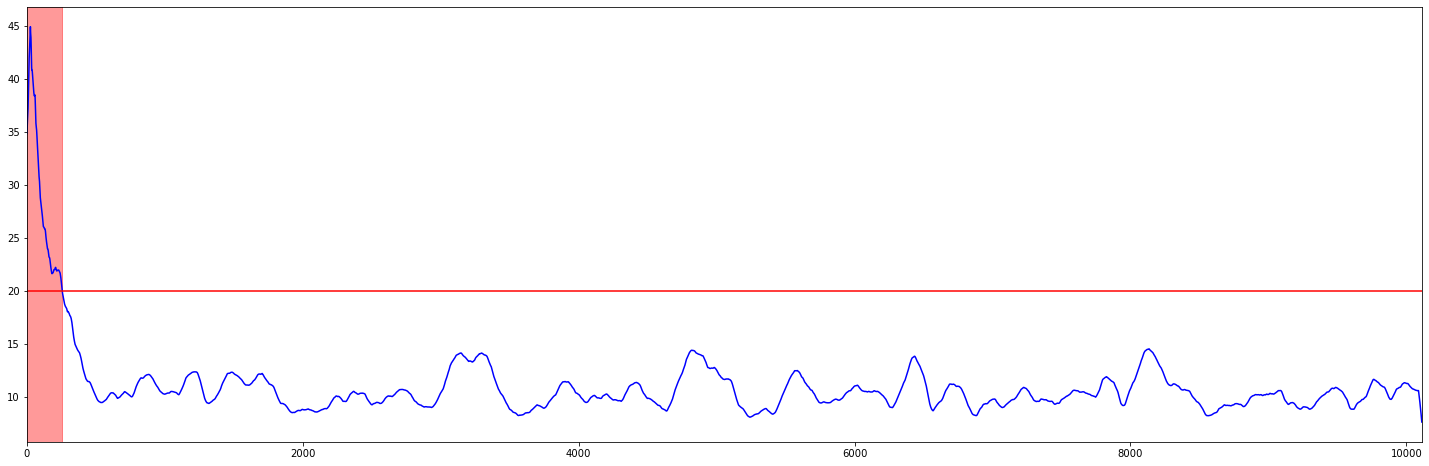

future :  1
(10240, 3)
out.shape= (1, 10240, 3)
X.shape: (10113, 128, 1)
10113


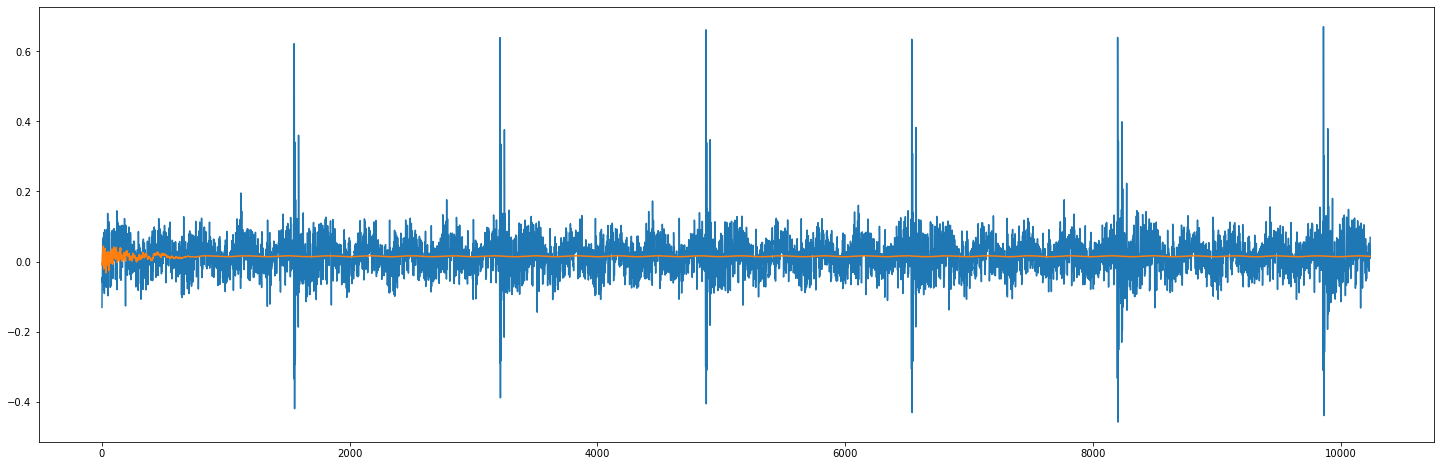

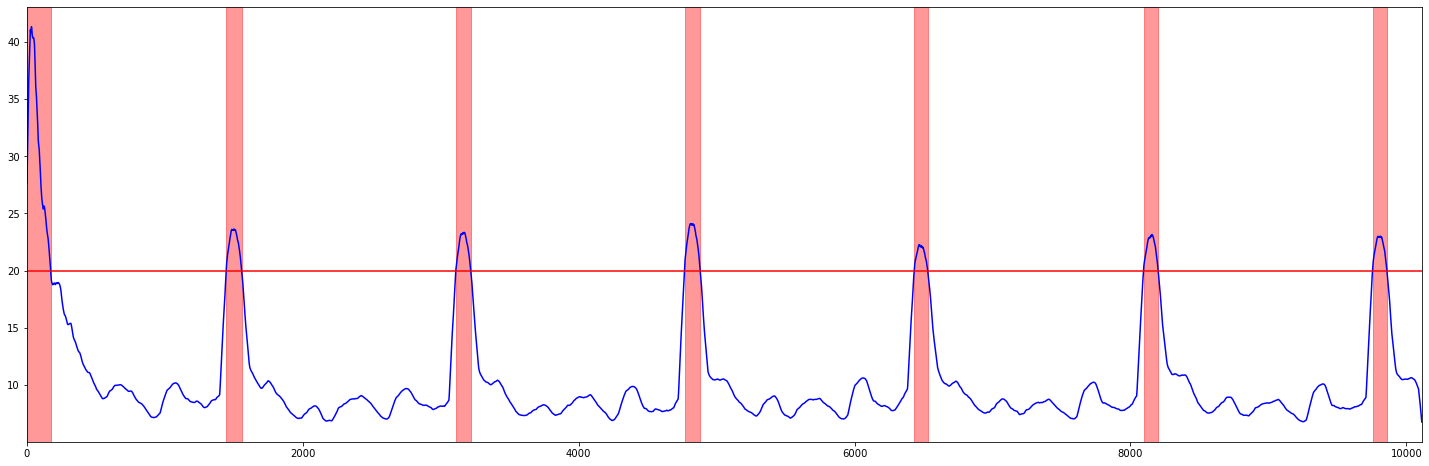

future :  2
(10240, 3)
out.shape= (1, 10240, 3)
X.shape: (10113, 128, 1)
10113


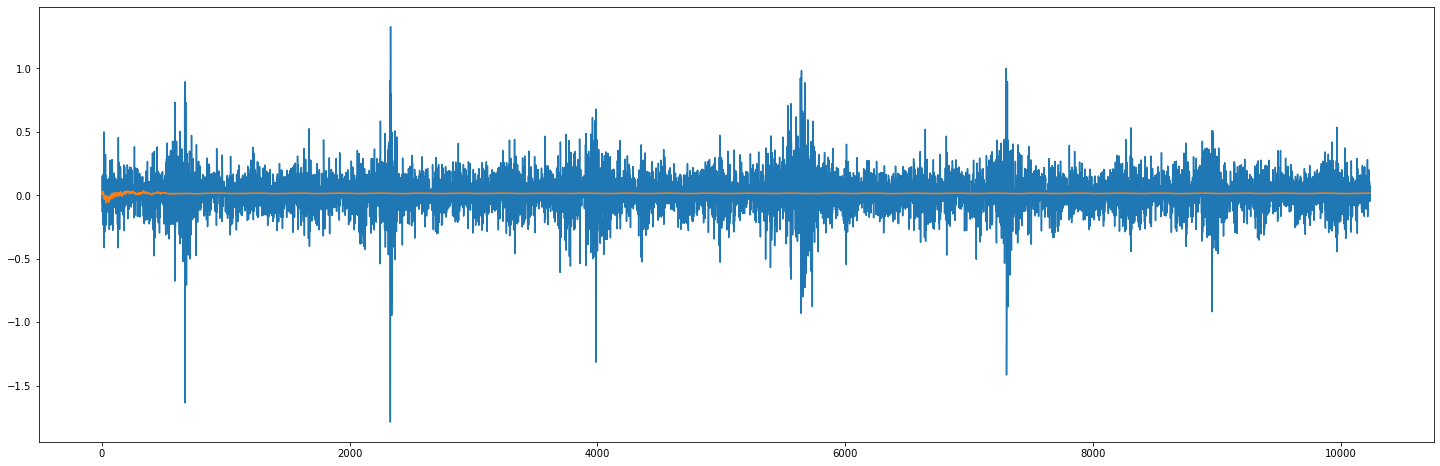

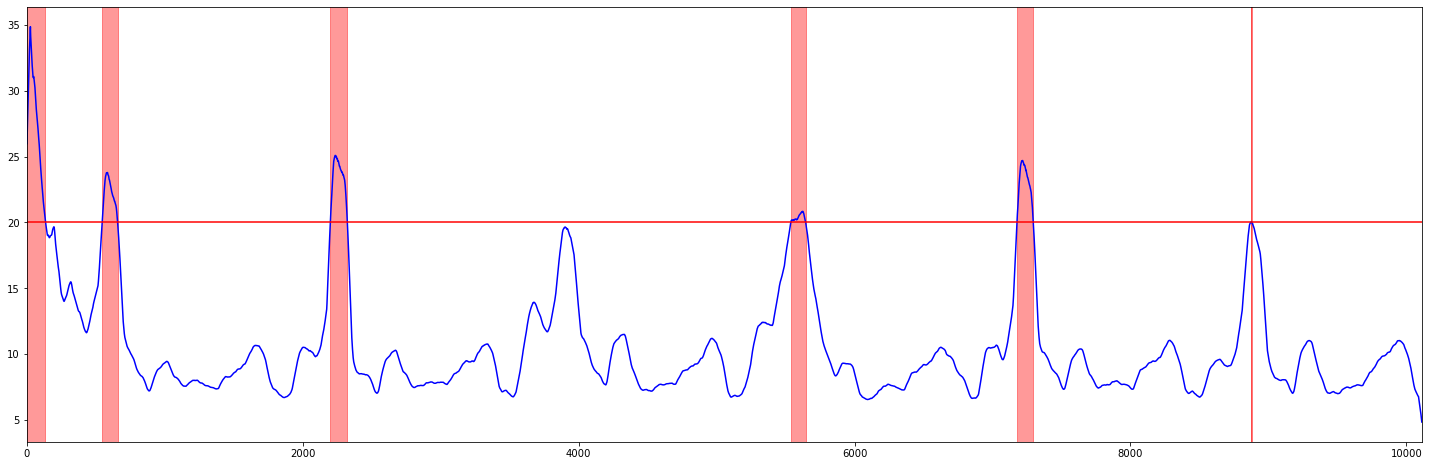

future :  3
(10240, 3)
out.shape= (1, 10240, 3)
X.shape: (10113, 128, 1)
10113


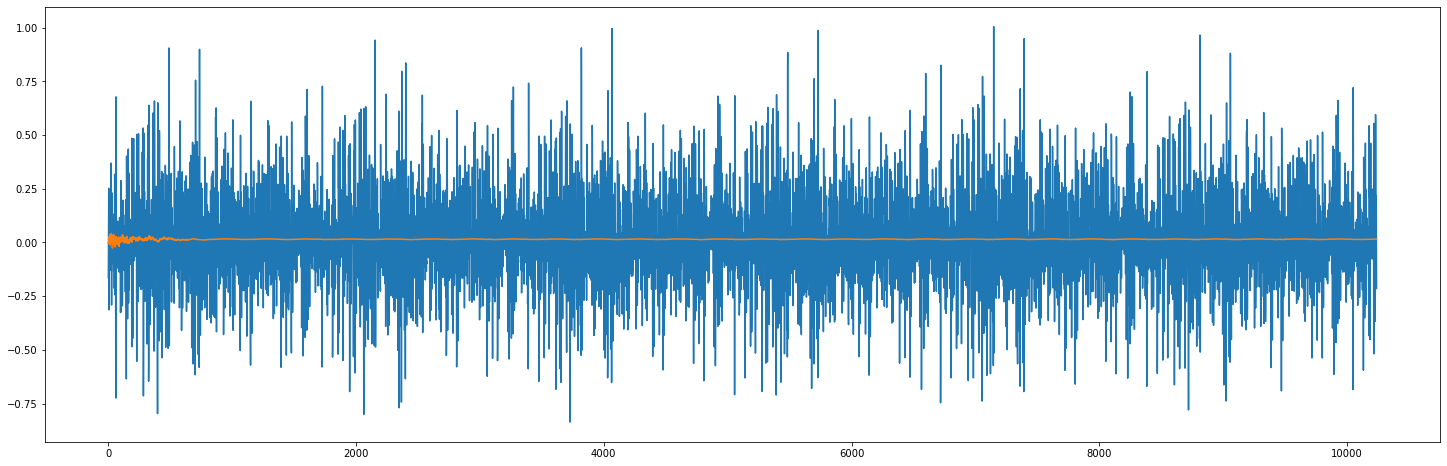

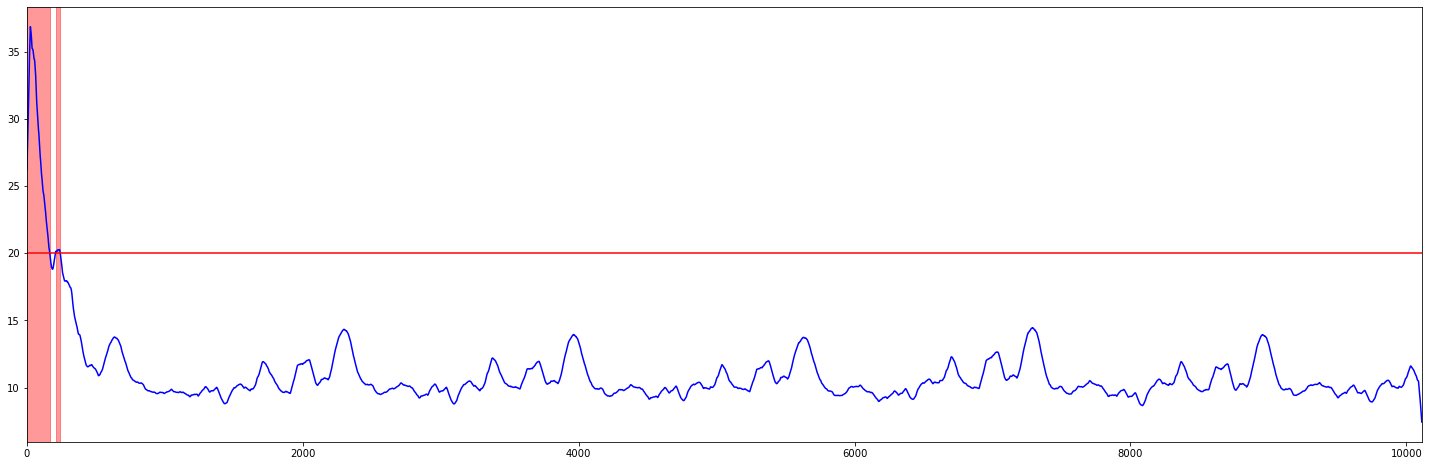

future :  4
(10240, 3)
out.shape= (1, 10240, 3)
X.shape: (10113, 128, 1)
10113


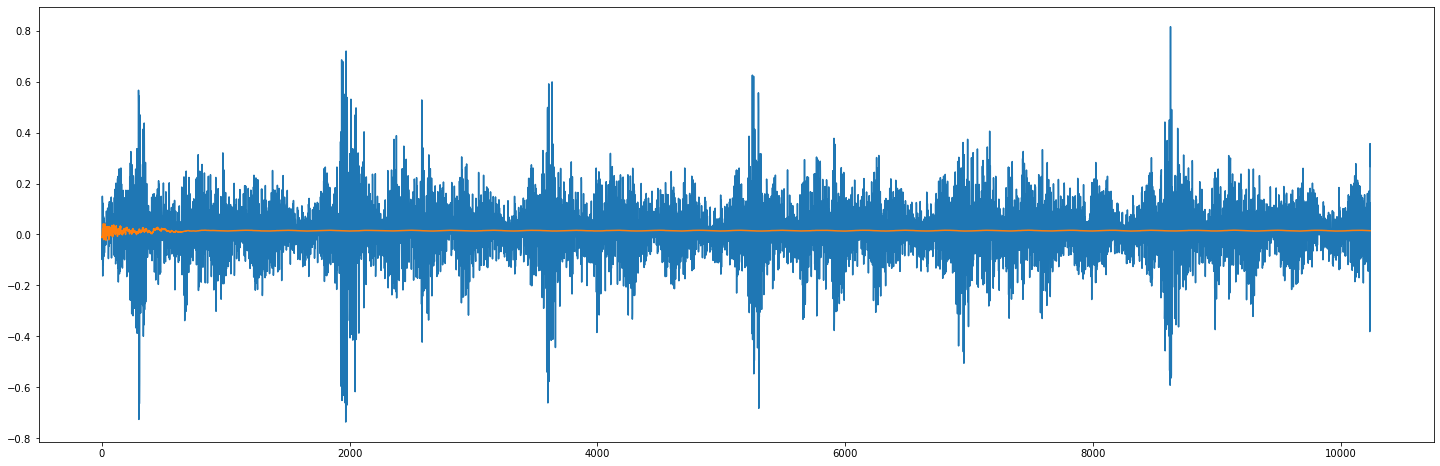

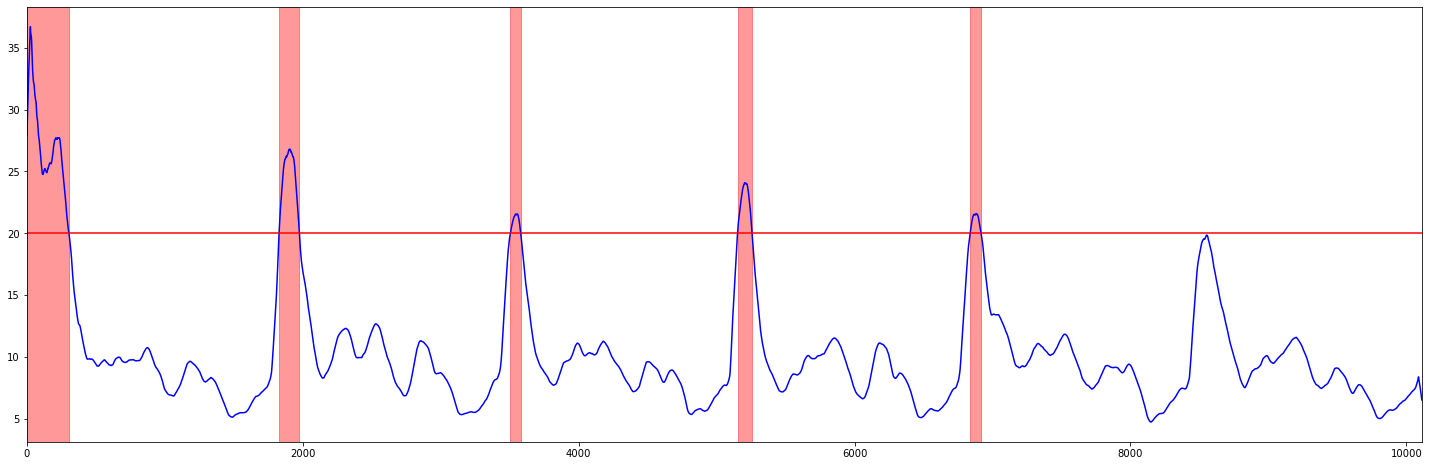

future :  5
(10240, 3)
out.shape= (1, 10240, 3)
X.shape: (10113, 128, 1)
10113


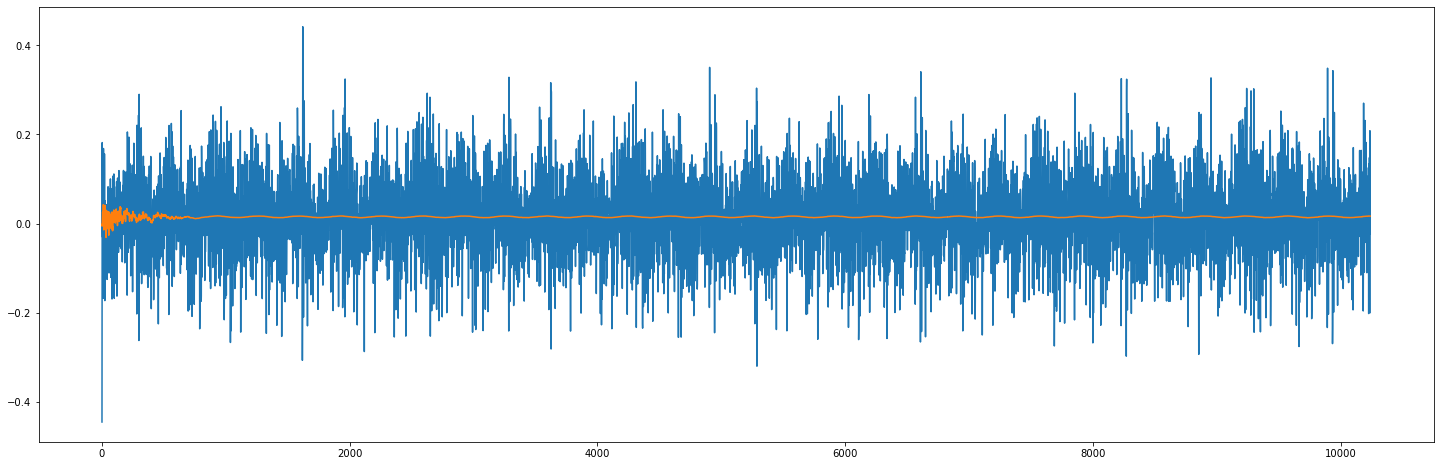

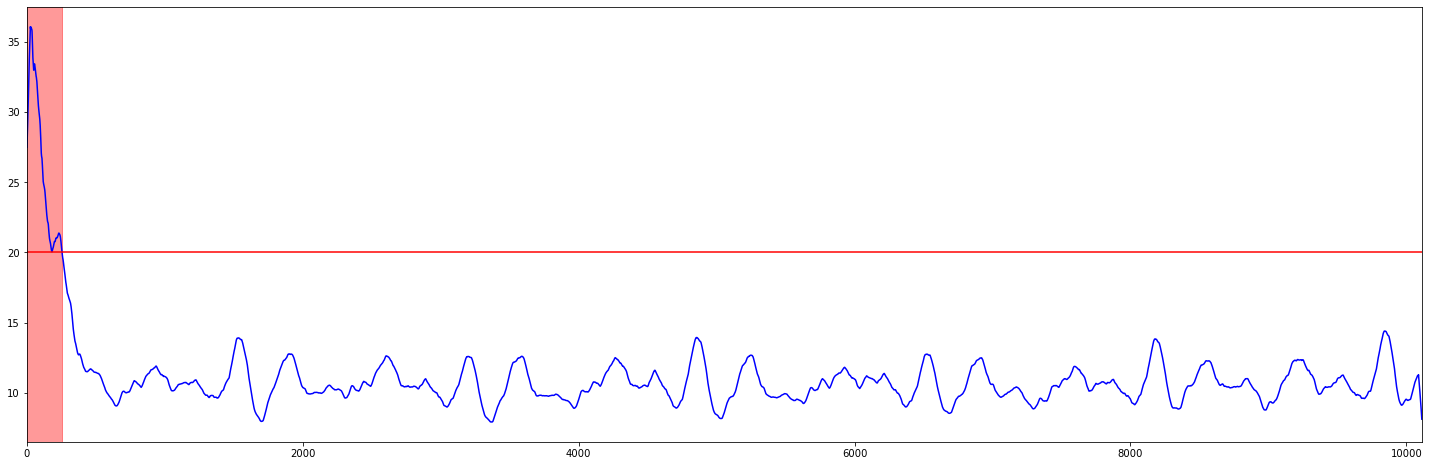

In [21]:
import plotly.graph_objects as go
# input_ = GOOD_1[0].reshape(1, 10240, 3)
# print(input_[0][:, 0].shape[0])
# pre = tcn_ae.model.predict(input_)
# print(pre.shape)
# for i in range(3):
#     out = pre[0][:, i]
#
#     plt.plot(input_[0][:, i])
#     plt.plot(out)
#     # plt.show()
#     plot_results(predict(input_[0][:, i], out), threshold=20)
def plot_res(data, ma=True, err=128):
    length = 10240
    data = data.reshape(-1, length, 3)[0][:length]
    print(data.shape)
    data = numpy.stack([lowpass_filter(data[:,0]),lowpass_filter(data[:,1]),lowpass_filter(data[:,2])])


    test = scaler.transform(data.T)
    # test = transform(data.reshape(-1, 10240, 3)[0])


    plt.figure(figsize=(25,8))
    test = test.reshape(1, length, 3)
    plt.plot(test.squeeze()[:,0])
    out = tcn_ae.model.predict(test)
    plt.plot(out.squeeze()[:,0])

    if ma:
        print('out.shape=',out.shape)
        score = predict(out[0][:,0].reshape(1,10240,1), test[0][:,0].reshape(1,10240,1), err)
    else:
        error_score = numpy.abs(test.squeeze() - out.squeeze())
        print(test.shape)

        score = numpy.sqrt((error_score[:,0] + error_score[:,1] + error_score[:,2])/3)*100
        score = numpy.convolve(score, numpy.ones((50,))/50, mode='same')
    # score = predict(test[0][:,0].reshape(1,10240,1),out[0][:,0].reshape(1,10240,1)) + \
    #         predict(test[0][:,1].reshape(1,10240,1),out[0][:,1].reshape(1,10240,1)) + \
    #         predict(test[0][:,2].reshape(1,10240,1),out[0][:,2].reshape(1,10240,1))

    plot_results(score, threshold=20)

# plot_res(all_data[0]['bot'])


for i in range(6):
    print('future : ',i)
    # plot_res(all_data_top[i])
    plot_res(all_data_mid[i])
    # plot_res(all_data_bot[i])



In [22]:
# for data in (all_data):
#     print(data.shape)
#     plt.plot(data[:, 0])
#     plt.show()
#     out = tcn_ae.model.predict(data[0].reshape(-1, 10240, 3))
#     plt.plot(data[0][:, 0])
#     plt.plot(out.squeeze()[:, 0])
#     plt.show()
#     re = predict(data[0][:, 0].reshape(-1, 10240, 1), out[:, :, 0].reshape(-1, 10240, 1))
#     plot_results(re, threshold=20)

In [23]:
# with tensorflow.device('/device:GPU:0'):
#     history =  tcn_ae.fit(GOOD_2, GOOD_2, batch_size=32, epochs=10000, verbose=2)
#     plt.plot(tcn_ae.history.history['loss'])

(10240, 3)
(1, 10240, 3)


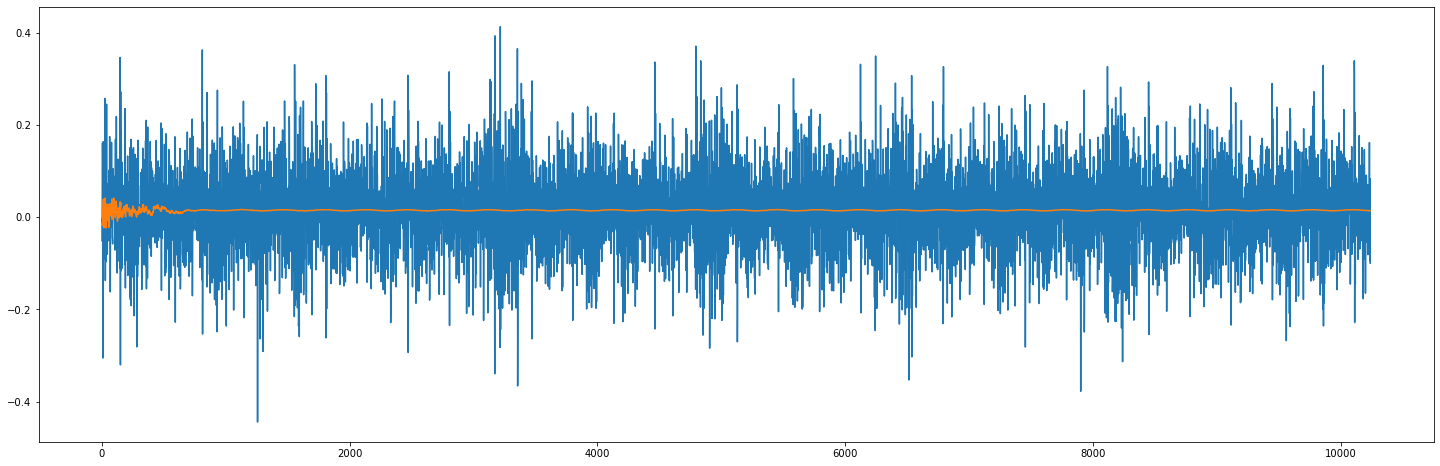

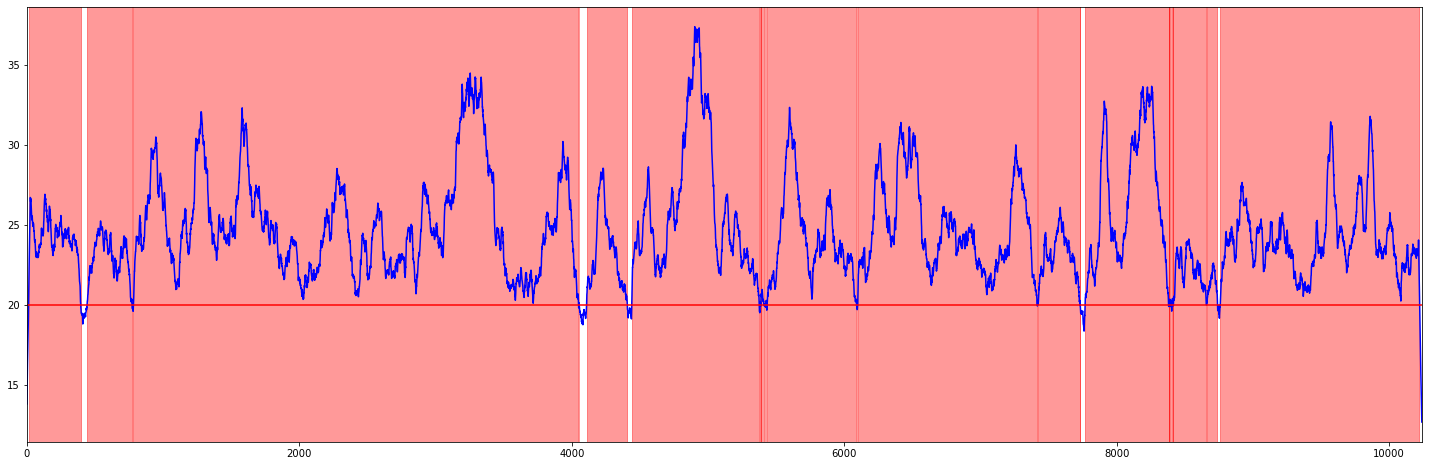

In [24]:
plot_res(all_data_mid[0],ma=False,err=64)

(10240, 3)
(1, 10240, 3)


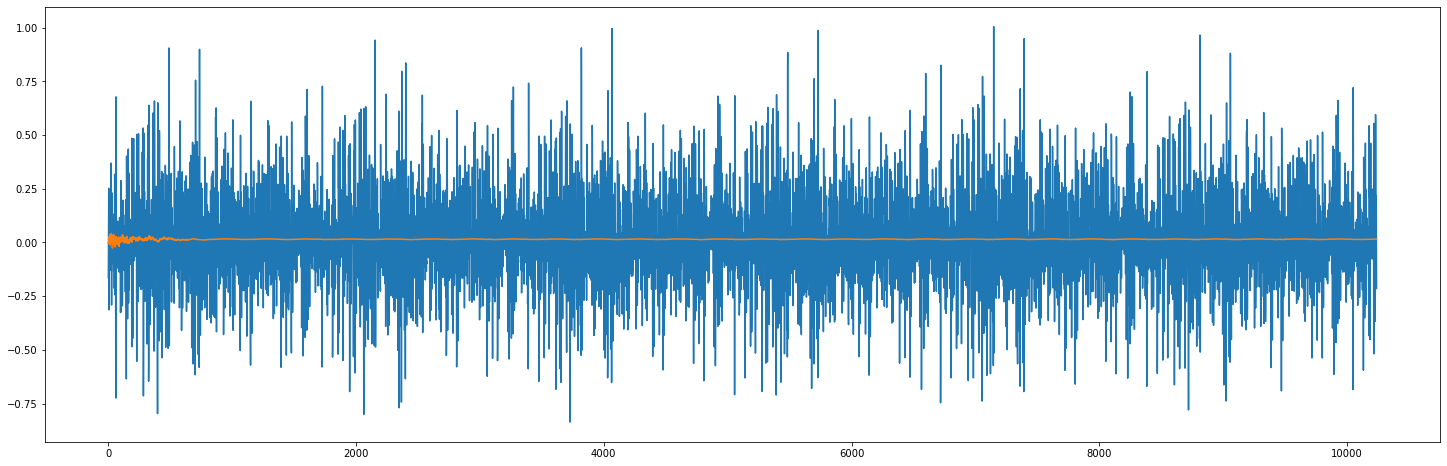

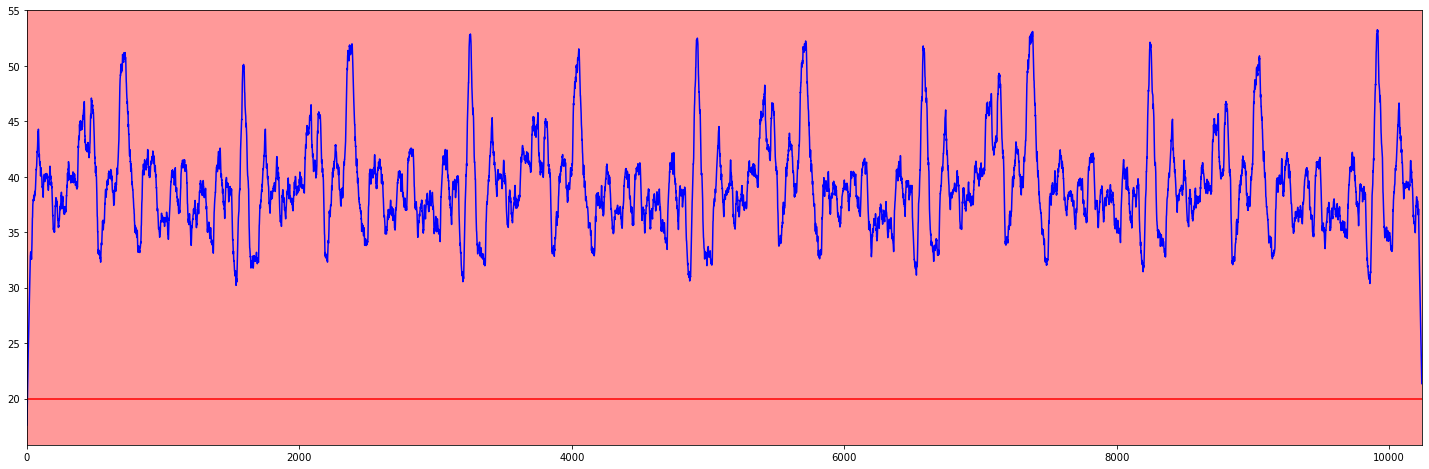

In [25]:
plot_res(all_data_mid[3], ma=False,err=64)